# House Pricing Prediction Portfolio



# Part 1 - Defining the problem that needs to be solved

Every one needs an enjoyable, happy place where you can live, laugh and learn. This is usually called HOME. Getting the correct evaluation for a house is very important as it is a major investment that is consequential for both the buyers and sellers.

There are various factors that influence the pricing of a house.

The goal of this portfolio is predicting prices for set of houses with reliable accuracy by examining details of features provided in a train data set.

### 1.1 Import Libraries

In [1]:
#Analysis packages
import pandas as pd
import sklearn as sk
import numpy as np
import scipy.stats as sp
import pandas.util.testing as tm

#Visualization packages
import matplotlib.pyplot as plt
import matplotlib as matplot
from matplotlib.ticker import MaxNLocator
import seaborn as sns

#Preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

#Models & Sklearn packages
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score as cvs
from sklearn.linear_model import LinearRegression as lr
from sklearn.ensemble import RandomForestRegressor as rfregr
from sklearn.ensemble import GradientBoostingRegressor as grbregr
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
#your info here
__author__ = "Laniya Oladapo"
__email__ = "laniyadapo@gmail.com"

<ipython-input-1-ecaef44cd386>:6: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1.2 Define Functions

In [2]:
class eda_process():
    def __init__(self, data):
        self.data = data
    
    # Number of missing values in each column of training data
    def perc_missing_data(self):
        percent = self.data.isnull().sum() / len(self.data)
        percent.sort_values(ascending=False)
        print("Percentage of missing values in each column:")
        print(percent[percent > 0])
    
    # Plotting the target variable to ispect for skewness
    def dist_plot(self, titles):
        self.titles = titles
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches(15, 5)
        sns.distplot(self.data, ax=ax[0])
        sns.distplot((np.log(self.data)), ax=ax[1])
        ax[0].title.set_text('Distribution of '+ self.titles)
        ax[1].title.set_text('Distribution of Log-Transformed ' + self.titles)
        fig.show()
        print(self.titles + ' has a skew of ' + str(self.data.skew().round(decimals=2)) + 
        ' while the log-transformed ' + self.titles + ' improves the skew to ' + 
        str(np.log(self.data).skew().round(decimals=2)))
    # Inspect all numerical feature for skewness
    def num_features_distplot(self):
        num_features = self.data.select_dtypes(exclude='object').drop('SalePrice', axis=1).copy()
        fig = plt.figure(figsize=(12,18))
        for i in range(len(num_features.columns)):
            fig.add_subplot(10,4,i+1)
            sns.distplot(num_features.iloc[:,i].dropna())
            plt.xlabel(num_features.columns[i])
        plt.tight_layout()
        plt.show()
    #Find outliers in numerical features using bivariate analysis
    def num_features_outliers(self):
        num_features = self.data.select_dtypes(exclude='object').drop('SalePrice', axis=1).copy()
        f = plt.figure(figsize=(12,20))
        for i in range(len(num_features.columns)):
            f.add_subplot(10, 4, i+1)
            sns.scatterplot(num_features.iloc[:,i], train_df.SalePrice)
        plt.tight_layout()
        plt.show()
    def heatmap_num(self, datatype):
        self.datatype = datatype
        sns.set(font_scale=1.1)
        correlation_train = self.data.corr()
        mask = np.triu(correlation_train.corr())
        plt.figure(figsize=(18, 20))
        plt.title('Correlation of ' + self.datatype, size=16)
        sns.heatmap(correlation_train,
                    annot=True,
                    fmt='.1f',
                    cmap='coolwarm',
                    square=True,
                    mask=mask,
                    linewidths=1,
                    cbar=False)
        plt.show()
    def heatmap(self, featuretype):
        self.featuretype = featuretype
        sns.set(font_scale=1.1)
        self.data = self.data.astype(float)
        correlation_train = self.data.corr()
        mask = np.triu(correlation_train.corr())
        plt.figure(figsize=(18, 20))
        plt.title('Correlation of ' + self.featuretype, size=16)
        sns.heatmap(correlation_train,
                    annot=True,
                    fmt='.1f',
                    cmap='coolwarm',
                    square=True,
                    mask=mask,
                    linewidths=1,
                    cbar=False)
        plt.show()
    def heatmap_all(self, featuretype):
        self.featuretype = featuretype
        sns.set(font_scale=1.1)
        self.data = self.data.astype(float)
        correlation_train = self.data.corr()
        mask = np.triu(correlation_train.corr())
        plt.figure(figsize=(50, 70))
        plt.title('Correlation of ' + self.featuretype, size=30)
        sns.heatmap(correlation_train,
                    annot=True,
                    fmt='.1f',
                    cmap='coolwarm',
                    square=True,
                    mask=mask,
                    linewidths=1,
                    cbar=False)
        plt.show()
    def corr_list(self):
        '''Plotting heatmap to show correlation of features'''
        correlation= self.data.corr()
        correlation['SalePrice'].sort_values(ascending=False).head(20)

    def cat_features_plot(self, col):
        self.col = col
        fig, axes = plt.subplots(14, 3, figsize=(25, 80))
        axes = axes.flatten()

        for i, j in zip(self.data.select_dtypes(include=['object']).columns, axes):
            sortd = self.data.groupby([i])[col].median().sort_values(ascending=False)
            sns.boxplot(x=i,
                        y=col,
                        data=self.data,
                        palette='plasma',
                        order=sortd.index,
                        ax=j)
            locator=MaxNLocator(prune='both', nbins=18)
            j.tick_params(labelrotation=45)
            j.yaxis.set_major_locator(locator)

            plt.tight_layout() 
    def deal_null_values(self, cols_cat, value):
        self.value = value
        for col in cols_cat:
            self.data[col].replace(np.nan, value, inplace=True)

## Part 2 - Data Discovery

### 2.1 Load Data 

In [3]:
#load the data into a Pandas dataframe
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

### 2.2 Examine & Get Insights on Data 

2.2.1 Inspecting the training set

In [4]:
#print the top 5 rows of training data
train_df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [5]:
#print the summary of the columns
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Observations:

1. The training data has 1460 rows and 81 features.
2. There are 38 numerical and 43 categorical data.

In [6]:
#print the descriptive statistics of the numerical data
train_df.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

In [7]:
train_df.select_dtypes(include=['object']).describe()

MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      1460   1460    91     1460        1460      1460      1460   
unique        5      2     2        4           4         2         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       1151   1454    50      925        1311      1459      1052   

       LandSlope Neighborhood Condition1  ... GarageType GarageFinish  \
count       1460         1460       1460  ...       1379         1379   
unique         3           25          9  ...          6            3   
top          Gtl        NAmes       Norm  ...     Attchd          Unf   
freq        1382          225       1260  ...        870          605   

       GarageQual GarageCond PavedDrive PoolQC  Fence MiscFeature SaleType  \
count        1379       1379       1460      7    281          54     1460   
unique          5          5          3      3      4           4        9   
top            TA         TA          Y     Gd  MnPrv        Shed       WD   
freq         1311       1326       1340      3    157          49     1267   

       SaleCondition  
count           1460  
unique             6  
top           Normal  
freq            1198  

[4 rows x 43 columns]

In [8]:
#print the percentage of missing data for columns with missing data
missing_values = eda_process(train_df)
missing_values.perc_missing_data()

Percentage of missing values in each column:
LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64


Observations:

1. There are 19 features with null values that will require further investigation to identify how to handle them. 5 of the 19 features namely: Alley, FireplaceQu, PoolQC, Fence, MiscFeature all have more than 50% null values hence will most likely be dropped.

2.2.2 Inspecting the testing data set

In [9]:
#print the top 5 rows of training data
test_df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

In [10]:
#print the summary of the columns
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

Observations:

1. The testing data has 1459 rows and 80 features.
2. There are 37 numerical and 43 categorical data.

In [11]:
#print the descriptive statistics of the numerical data
test_df.describe()

Id   MSSubClass  LotFrontage       LotArea  OverallQual  \
count  1459.000000  1459.000000  1232.000000   1459.000000  1459.000000   
mean   2190.000000    57.378341    68.580357   9819.161069     6.078821   
std     421.321334    42.746880    22.376841   4955.517327     1.436812   
min    1461.000000    20.000000    21.000000   1470.000000     1.000000   
25%    1825.500000    20.000000    58.000000   7391.000000     5.000000   
50%    2190.000000    50.000000    67.000000   9399.000000     6.000000   
75%    2554.500000    70.000000    80.000000  11517.500000     7.000000   
max    2919.000000   190.000000   200.000000  56600.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1459.000000  1459.000000   1459.000000  1444.000000  1458.000000  ...   
mean      5.553804  1971.357779   1983.662783   100.709141   439.203704  ...   
std       1.113740    30.390071     21.130467   177.625900   455.268042  ...   
min       1.000000  1879.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1953.000000   1963.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1992.000000     0.000000   350.500000  ...   
75%       6.000000  2001.000000   2004.000000   164.000000   753.500000  ...   
max       9.000000  2010.000000   2010.000000  1290.000000  4010.000000  ...   

        GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count  1458.000000  1459.000000  1459.000000    1459.000000  1459.000000   
mean    472.768861    93.174777    48.313914      24.243317     1.794380   
std     217.048611   127.744882    68.883364      67.227765    20.207842   
min       0.000000     0.000000     0.000000       0.000000     0.000000   
25%     318.000000     0.000000     0.000000       0.000000     0.000000   
50%     480.000000     0.000000    28.000000       0.000000     0.000000   
75%     576.000000   168.000000    72.000000       0.000000     0.000000   
max    1488.000000  1424.000000   742.000000    1012.000000   360.000000   

       ScreenPorch     PoolArea       MiscVal       MoSold       YrSold  
count  1459.000000  1459.000000   1459.000000  1459.000000  1459.000000  
mean     17.064428     1.744345     58.167923     6.104181  2007.769705  
std      56.609763    30.491646    630.806978     2.722432     1.301740  
min       0.000000     0.000000      0.000000     1.000000  2006.000000  
25%       0.000000     0.000000      0.000000     4.000000  2007.000000  
50%       0.000000     0.000000      0.000000     6.000000  2008.000000  
75%       0.000000     0.000000      0.000000     8.000000  2009.000000  
max     576.000000   800.000000  17000.000000    12.000000  2010.000000  

[8 rows x 37 columns]

In [12]:
test_df.select_dtypes(include=['object']).describe()

MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      1455   1459   107     1459        1459      1457      1459   
unique        5      2     2        4           4         1         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       1114   1453    70      934        1311      1457      1081   

       LandSlope Neighborhood Condition1  ... GarageType GarageFinish  \
count       1459         1459       1459  ...       1383         1381   
unique         3           25          9  ...          6            3   
top          Gtl        NAmes       Norm  ...     Attchd          Unf   
freq        1396          218       1251  ...        853          625   

       GarageQual GarageCond PavedDrive PoolQC  Fence MiscFeature SaleType  \
count        1381       1381       1459      3    290          51     1458   
unique          4          5          3      2      4           3        9   
top            TA         TA          Y     Ex  MnPrv        Shed       WD   
freq         1293       1328       1301      2    172          46     1258   

       SaleCondition  
count           1459  
unique             6  
top           Normal  
freq            1204  

[4 rows x 43 columns]

In [13]:
#print the percentage of missing data for columns with missing data
missing_values = eda_process(test_df)
missing_values.perc_missing_data()

Percentage of missing values in each column:
MSZoning        0.002742
LotFrontage     0.155586
Alley           0.926662
Utilities       0.001371
Exterior1st     0.000685
Exterior2nd     0.000685
MasVnrType      0.010966
MasVnrArea      0.010281
BsmtQual        0.030158
BsmtCond        0.030843
BsmtExposure    0.030158
BsmtFinType1    0.028787
BsmtFinSF1      0.000685
BsmtFinType2    0.028787
BsmtFinSF2      0.000685
BsmtUnfSF       0.000685
TotalBsmtSF     0.000685
BsmtFullBath    0.001371
BsmtHalfBath    0.001371
KitchenQual     0.000685
Functional      0.001371
FireplaceQu     0.500343
GarageType      0.052090
GarageYrBlt     0.053461
GarageFinish    0.053461
GarageCars      0.000685
GarageArea      0.000685
GarageQual      0.053461
GarageCond      0.053461
PoolQC          0.997944
Fence           0.801234
MiscFeature     0.965045
SaleType        0.000685
dtype: float64


Observations:

1. There are 33 features with null values that will require further investigation to identify how to handle them. 5 of the 33 features namely: Alley, FireplaceQu, PoolQC, Fence, MiscFeature all have more than 50% null values hence will most likely be dropped.

### 2.3 Clean & Exploring data

2.3.1 Checking for duplicates in data and dropping applicable column

In [14]:
#Checking for duplicated Id in data
train_df['Id'].is_unique

True

In [15]:
#dropping Id column as it is not useful for modelling
train_df.drop(columns =['Id'], inplace=True)
train_df.shape

(1460, 80)

2.3.2 Inspecting columns for skewness in target feature

SalePrice has a skew of 1.88 while the log-transformed SalePrice improves the skew to 0.12


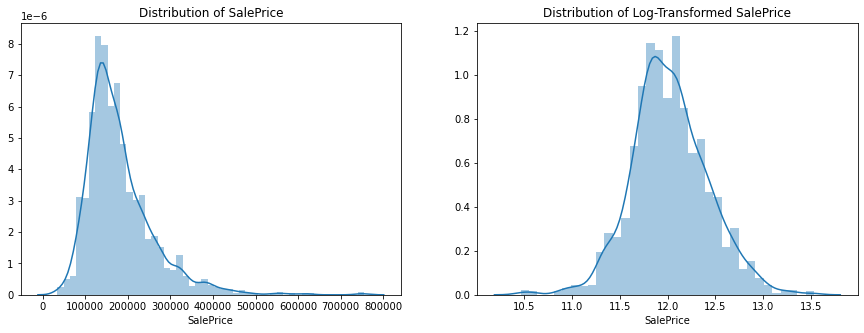

In [16]:
#SalePrice inspection for skewness
plot = eda_process(train_df.SalePrice)
plot.dist_plot('SalePrice')

Observation: Log Transformation of the SalePrice data minimizes the skewness in the data.

2.3.3 Inspecting numerical features columns for skewness 

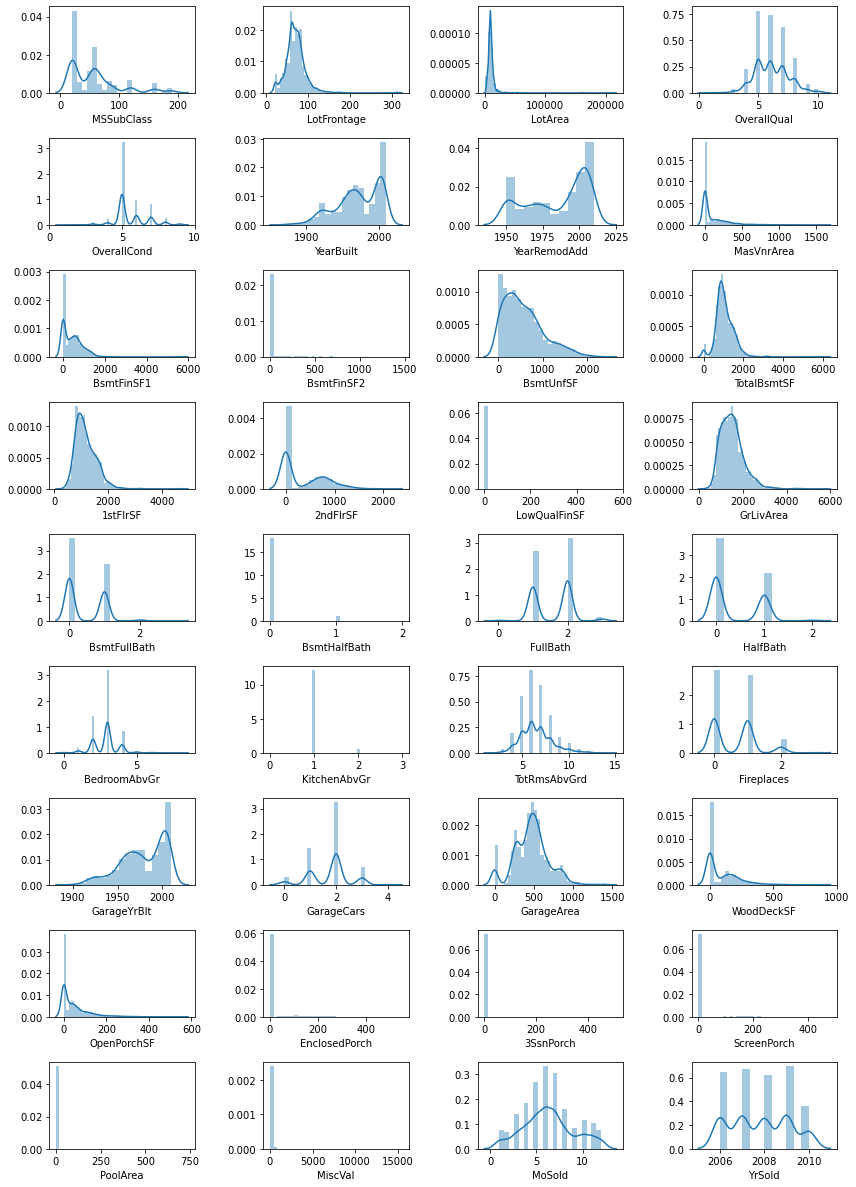

In [17]:
#Numeric features inspection for skewness
num_distribution_plot = eda_process(train_df)
num_distribution_plot.num_features_distplot()

Observations:
1. 5 features identified with uni-modal, skewed distributions could potentially be log transformed if selected for modelling.
  - LotFrontage, LotArea, 1stFlrSF, GrLivArea & OpenPorchSF

2.3.4 Checking numerical features for outliers using the bivariate analysis method

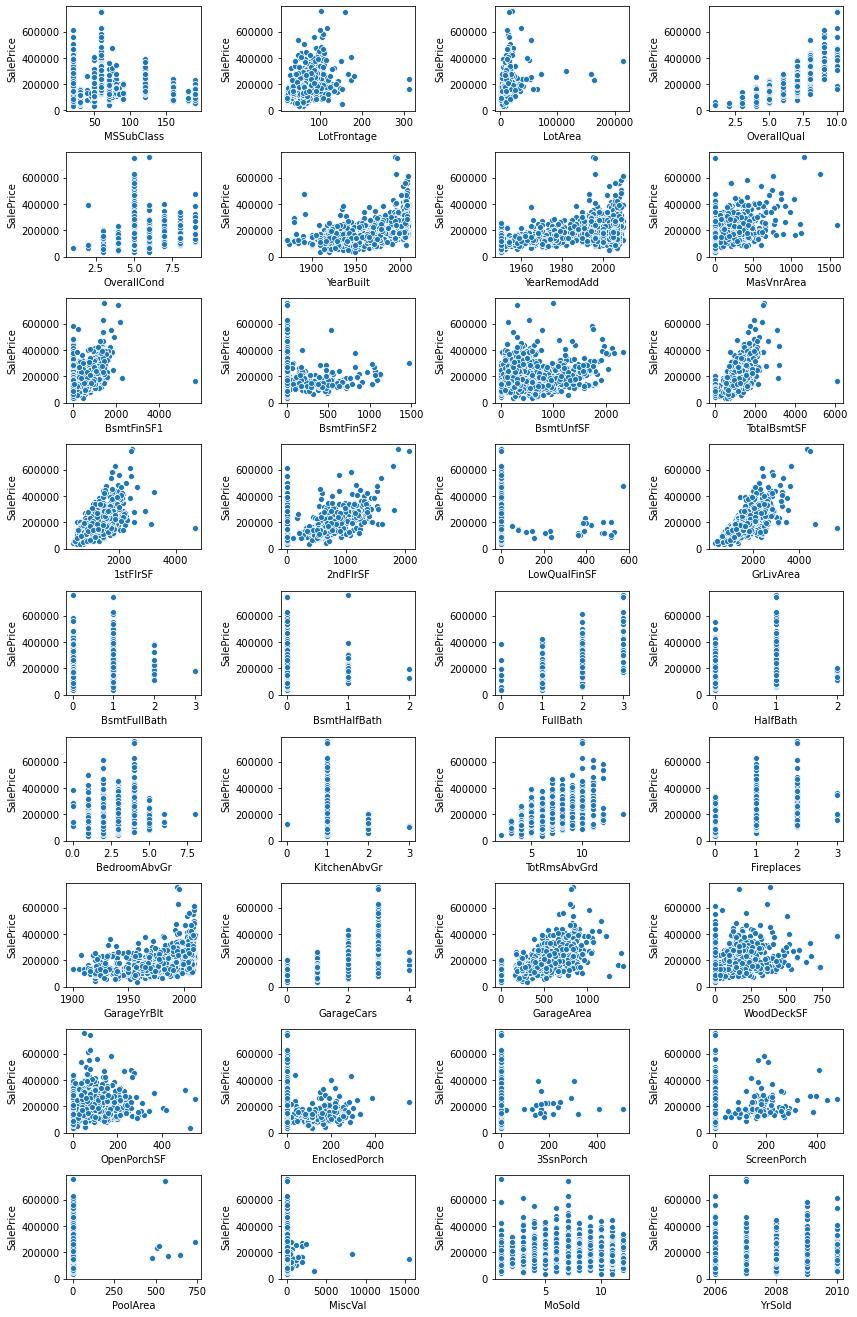

In [18]:
#Numeric features inspection for outliers
num_bivariate_plot = eda_process(train_df)
num_bivariate_plot.num_features_outliers()

Observations:
1. Following features appear to have outliers based on scatter plots above.
   - LotFrontage (> 200), Lot Area (> 100000), BsmtFinSF1 (> 4000), TotalBsmtSF (>4000), 1stFlrSF (> 4000)

2.3.5 Checking numerical features for correlation

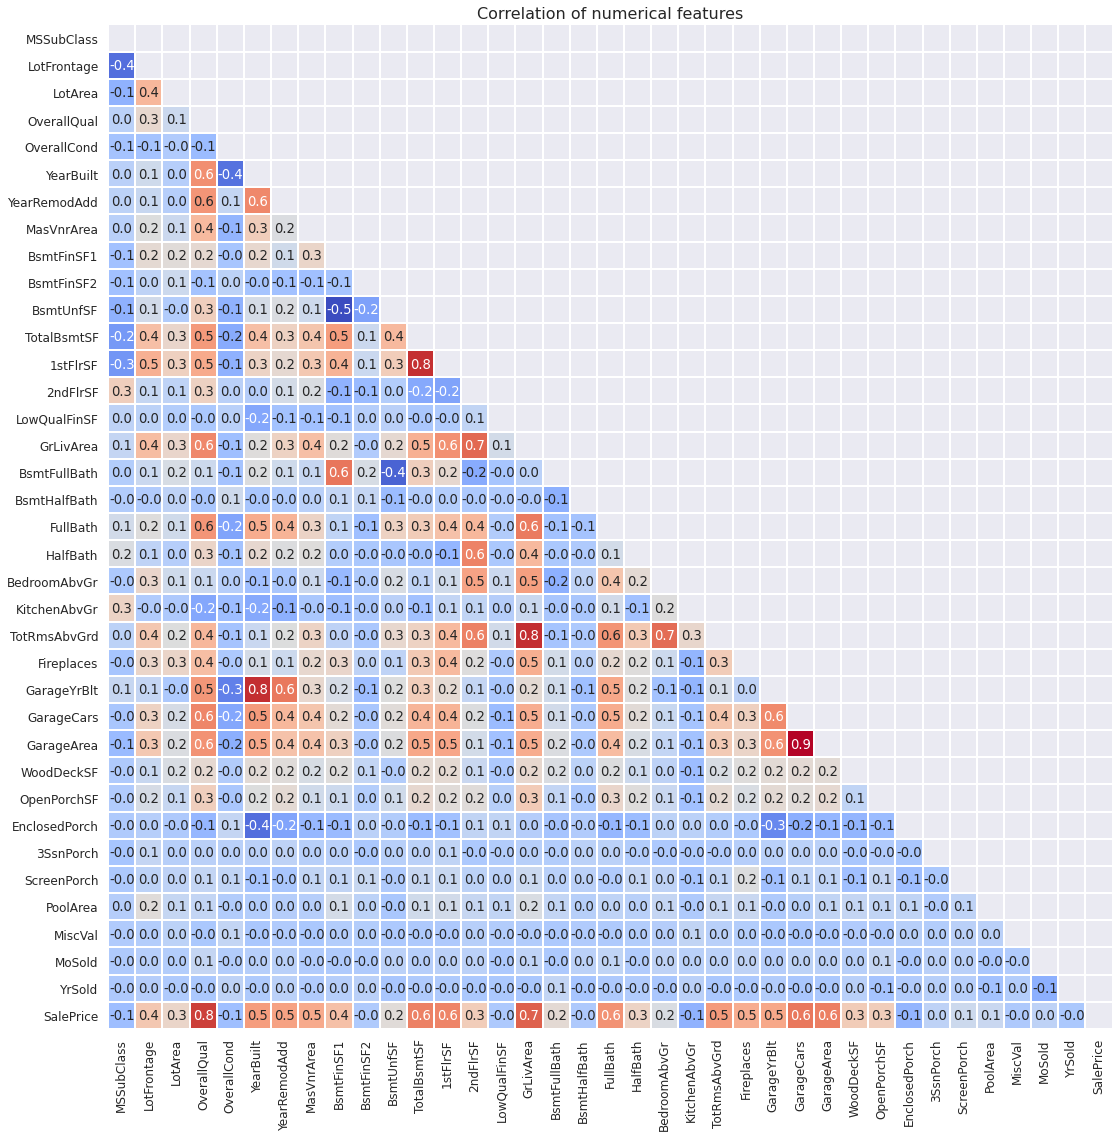

In [19]:
#Heatmap for numerical features correlation
num_feature_corr = eda_process(train_df)
num_feature_corr.heatmap_num('numerical features')

2.3.5 Checking for correlation of the numerical features with SalePrice

In [20]:
#Sorted list of numerical features correlation with SalePrice
list =  train_df.corr()
list['SalePrice'].sort_values(ascending=False).head(36)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
Name: SalePrice, dtype: float64

Observations: 

1. The following features will be excluded due to high correlation to other features that are highly correlated to SalePrice-
    - Garage Area- highly correlated to Garage Cars
    - 1stFlrSF- highly correlated to TotalBsmtSF
    - GarageYrBlt - highly correlated to YearBuilt
    - TotRmsAbvGrd - highly correlated to GrLivArea
2. Following features to be excluded due to low correlation to SalePrice - MoSold, 3SsnPorch, BsmtFinSF2, BsmtHalfBath, MiscVal, 
   LowQualFinSF, YrSold, OverallCond, MSSubClass, EnclosedPorch.

2.3.6 Checking for relationship between the categorical features and SalePrice

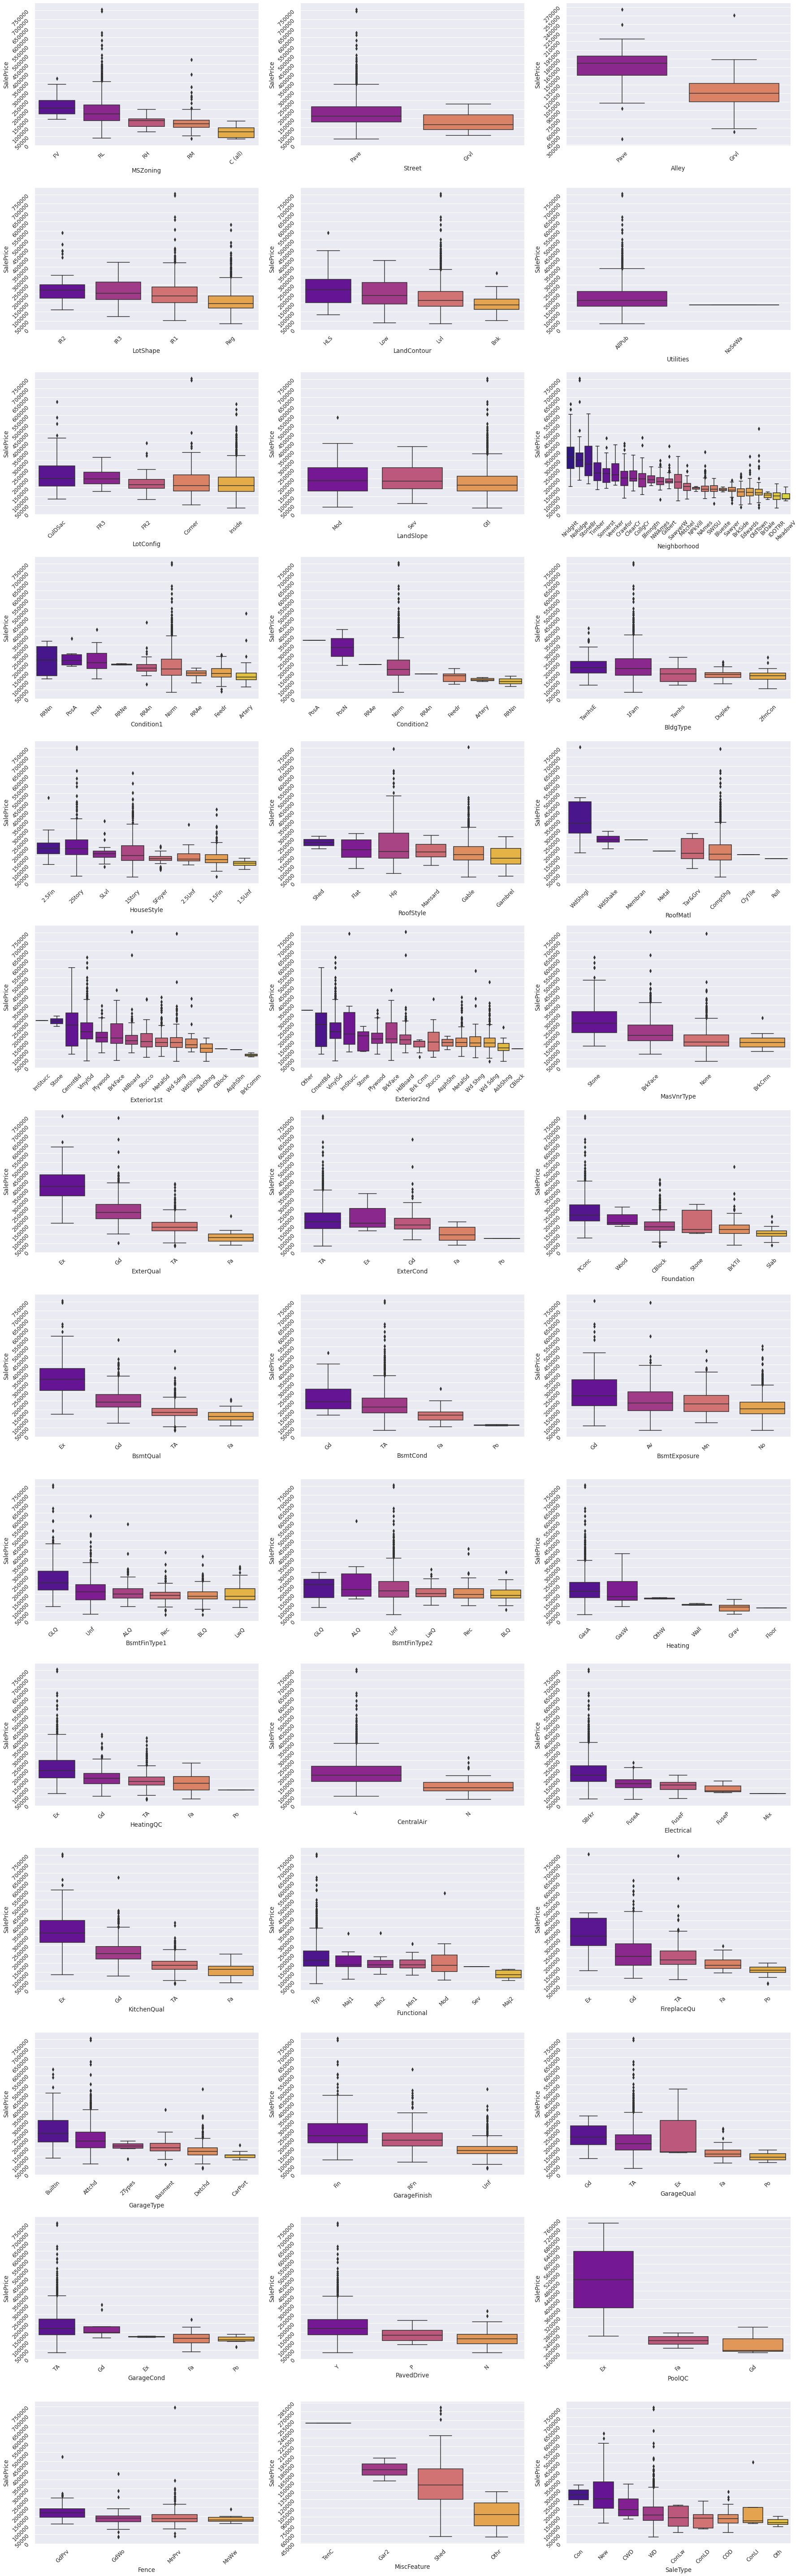

In [21]:
#Plot to inspect relationshop between categorical features and SalePrice
cat_plot = eda_process(train_df)
cat_plot.cat_features_plot('SalePrice')

In [22]:
cat_features = train_df.select_dtypes(include=['object'])
cat_features.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [23]:
analysis_data = train_df.copy()

In [24]:
missing_value = eda_process(analysis_data)
missing_value.perc_missing_data()

Percentage of missing values in each column:
LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64


In [25]:
None_cols = ['Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
none_replace = eda_process(analysis_data)
none_replace.deal_null_values(None_cols, 'None')

In [26]:
zero_cols = ['GarageYrBlt', 'MasVnrArea']
none_replace = eda_process(analysis_data)
none_replace.deal_null_values(zero_cols, 0)

In [27]:
freq_cols = ['Electrical']
none_replace = eda_process(analysis_data)
none_replace.deal_null_values(freq_cols, analysis_data['Electrical'].mode()[0])

In [28]:
features = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition']
analysis_data[features]=analysis_data[features].astype('category')
analysis_data.dtypes

MSSubClass          int64
MSZoning         category
LotFrontage       float64
LotArea             int64
Street           category
                   ...   
MoSold              int64
YrSold              int64
SaleType         category
SaleCondition    category
SalePrice           int64
Length: 80, dtype: object

In [29]:
analysis_data.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave  None      Reg   
1          20       RL         80.0     9600   Pave  None      Reg   
2          60       RL         68.0    11250   Pave  None      IR1   
3          70       RL         60.0     9550   Pave  None      IR1   
4          60       RL         84.0    14260   Pave  None      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0   None  None        None   
1         Lvl    AllPub       FR2  ...        0   None  None        None   
2         Lvl    AllPub    Inside  ...        0   None  None        None   
3         Lvl    AllPub    Corner  ...        0   None  None        None   
4         Lvl    AllPub       FR2  ...        0   None  None        None   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal     208500  
1       0      5    2007        WD         Normal     181500  
2       0      9    2008        WD         Normal     223500  
3       0      2    2006        WD        Abnorml     140000  
4       0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

In [30]:
analysis_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [31]:
def encode_label(df, col):
    cat_dict = {}
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = train_df[train_df[col] == cat]['SalePrice'].mean()
    df[col] = df[col].map(cat_dict)

In [32]:
#apply the encode_label function on categorical data
for col in analysis_data.columns:
  if analysis_data[col].dtype.name == 'category':
    encode_label(analysis_data, col)

In [33]:
analysis_data[features]

MSZoning         Street  Alley       LotShape    LandContour  \
0     191004.994787  181130.538514    NaN  164754.818378  180183.746758   
1     191004.994787  181130.538514    NaN  164754.818378  180183.746758   
2     191004.994787  181130.538514    NaN  206101.665289  180183.746758   
3     191004.994787  181130.538514    NaN  206101.665289  180183.746758   
4     191004.994787  181130.538514    NaN  206101.665289  180183.746758   
...             ...            ...    ...            ...            ...   
1455  191004.994787  181130.538514    NaN  164754.818378  180183.746758   
1456  191004.994787  181130.538514    NaN  164754.818378  180183.746758   
1457  191004.994787  181130.538514    NaN  164754.818378  180183.746758   
1458  191004.994787  181130.538514    NaN  164754.818378  180183.746758   
1459  191004.994787  181130.538514    NaN  164754.818378  180183.746758   

         Utilities      LotConfig      LandSlope   Neighborhood  \
0     180950.95682  176938.047529  179956.799566  197965.773333   
1     180950.95682  177934.574468  179956.799566  238772.727273   
2     180950.95682  176938.047529  179956.799566  197965.773333   
3     180950.95682  181623.425856  179956.799566  210624.725490   
4     180950.95682  177934.574468  179956.799566  335295.317073   
...            ...            ...            ...            ...   
1455  180950.95682  176938.047529  179956.799566  192854.506329   
1456  180950.95682  176938.047529  179956.799566  189050.068493   
1457  180950.95682  176938.047529  179956.799566  210624.725490   
1458  180950.95682  176938.047529  179956.799566  145847.080000   
1459  180950.95682  176938.047529  179956.799566  128219.700000   

         Condition1  ...     GarageType   GarageFinish     GarageQual  \
0     184495.492063  ...  202892.656322  202068.869668  187489.836003   
1     142475.481481  ...  202892.656322  202068.869668  187489.836003   
2     184495.492063  ...  202892.656322  202068.869668  187489.836003   
3     184495.492063  ...  134091.162791  142156.423140  187489.836003   
4     184495.492063  ...  202892.656322  202068.869668  187489.836003   
...             ...  ...            ...            ...            ...   
1455  184495.492063  ...  202892.656322  202068.869668  187489.836003   
1456  184495.492063  ...  202892.656322  142156.423140  187489.836003   
1457  184495.492063  ...  202892.656322  202068.869668  187489.836003   
1458  184495.492063  ...  202892.656322  142156.423140  187489.836003   
1459  184495.492063  ...  202892.656322  240052.690341  187489.836003   

         GarageCond     PavedDrive PoolQC          Fence    MiscFeature  \
0     187885.735294  186433.973881    NaN            NaN            NaN   
1     187885.735294  186433.973881    NaN            NaN            NaN   
2     187885.735294  186433.973881    NaN            NaN            NaN   
3     187885.735294  186433.973881    NaN            NaN            NaN   
4     187885.735294  186433.973881    NaN            NaN            NaN   
...             ...            ...    ...            ...            ...   
1455  187885.735294  186433.973881    NaN            NaN            NaN   
1456  187885.735294  186433.973881    NaN  148751.089172            NaN   
1457  187885.735294  186433.973881    NaN  178927.457627  151187.612245   
1458  187885.735294  186433.973881    NaN            NaN            NaN   
1459  187885.735294  186433.973881    NaN            NaN            NaN   

           SaleType  SaleCondition  
0     173401.836622  175202.219533  
1     173401.836622  175202.219533  
2     173401.836622  175202.219533  
3     173401.836622  146526.623762  
4     173401.836622  175202.219533  
...             ...            ...  
1455  173401.836622  175202.219533  
1456  173401.836622  175202.219533  
1457  173401.836622  175202.219533  
1458  173401.836622  175202.219533  
1459  173401.836622  175202.219533  

[1460 rows x 43 columns]

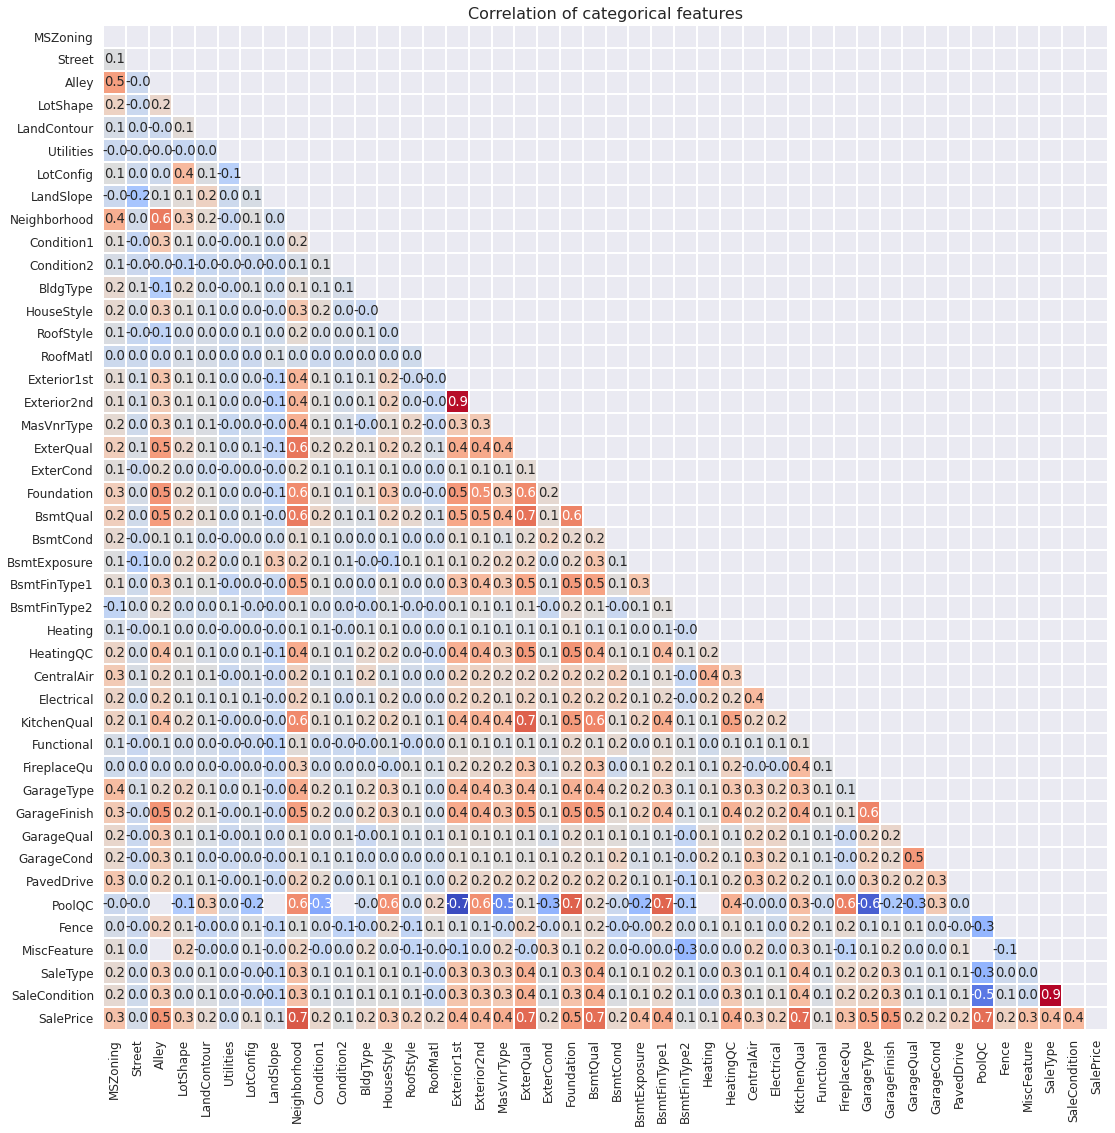

In [34]:
#Heatmap for categorical features correlation
cat_feature_corr = eda_process(analysis_data[features + ['SalePrice']])
cat_feature_corr.heatmap('categorical features')

In [46]:
#Sorted list of categorical features correlation with SalePrice
list_cat =  analysis_data[features + ['SalePrice']].corr()
list_cat['SalePrice'].sort_values(ascending=False).head(50)

SalePrice       1.000000
BsmtQual        0.673614
PoolQC          0.669814
Alley           0.534319
GarageFinish    0.516988
GarageType      0.454575
BsmtFinType1    0.438859
BsmtExposure    0.361131
MiscFeature     0.338534
FireplaceQu     0.336366
Fence           0.225531
BsmtCond        0.169731
GarageQual      0.164640
GarageCond      0.164395
BsmtFinType2    0.097223
Name: SalePrice, dtype: float64

Observations: 

1. The following features will be excluded due to high correlation to other features that are highly correlated to SalePrice-
    - Sale Condition- highly correlated to SaleType
    - Exterior2nd- highly correlated to Exterior1st
2. Following features to be excluded due to low correlation to SalePrice - Street, Utilities. 

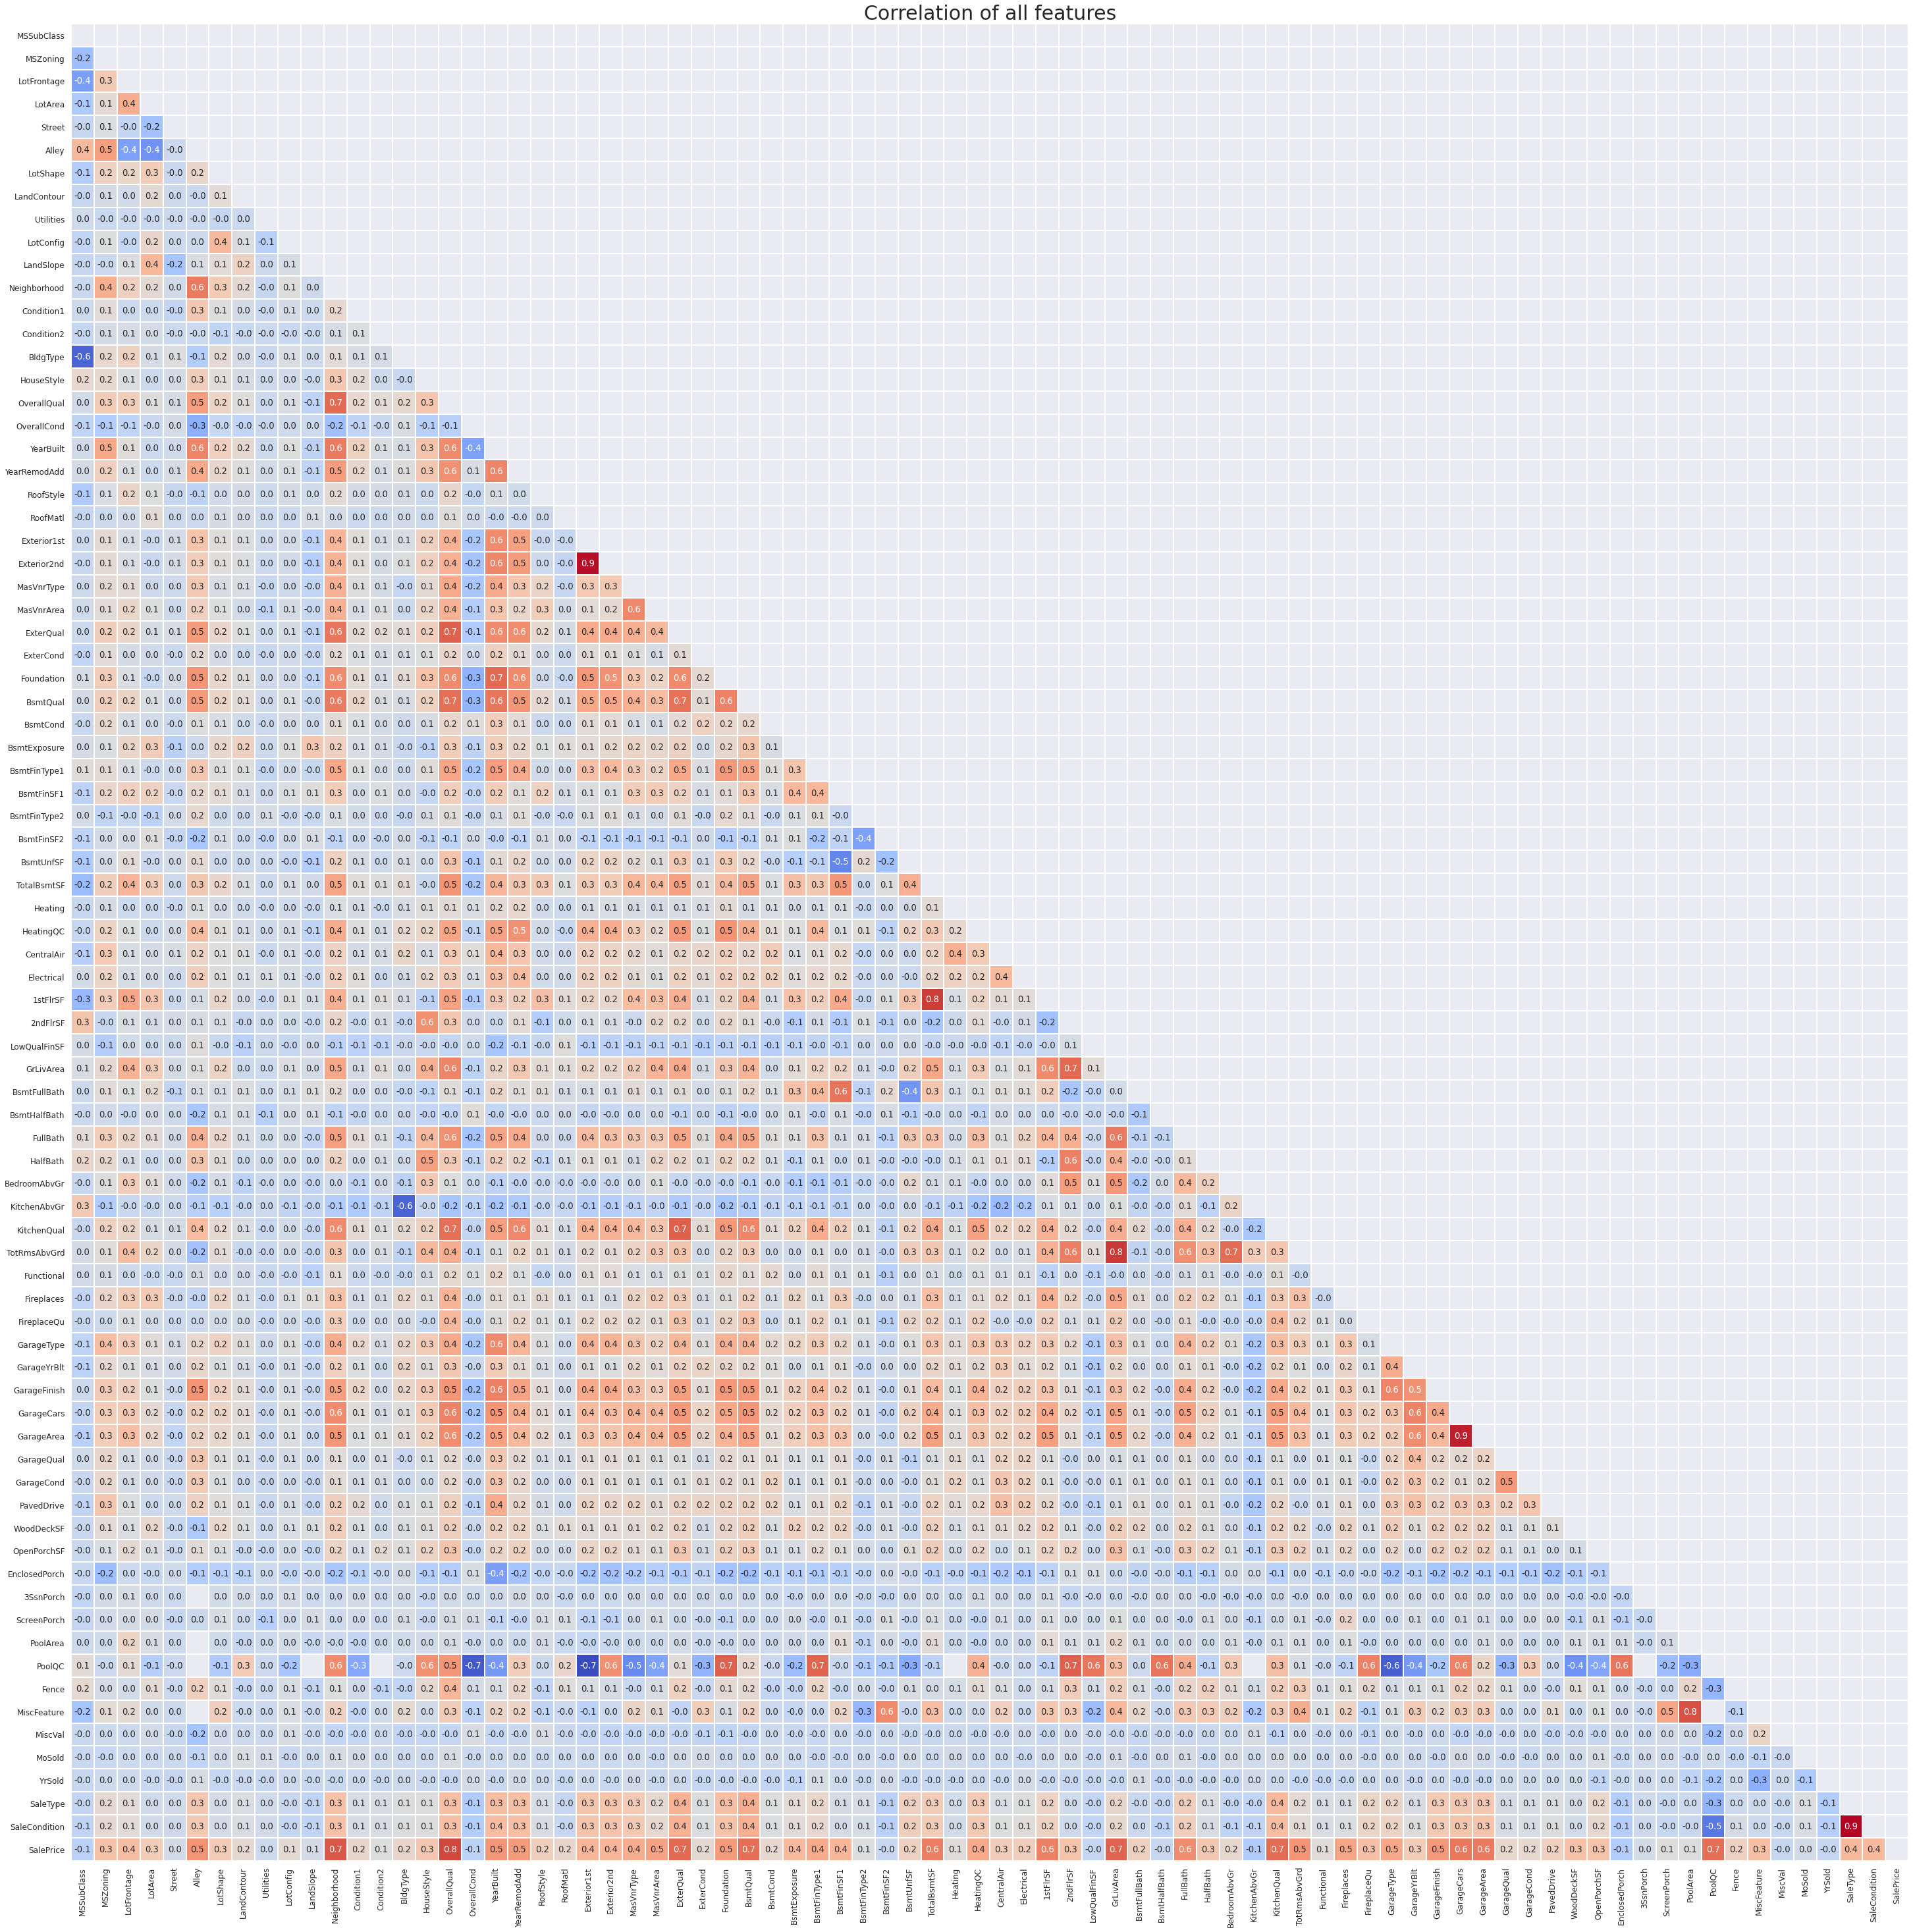

In [36]:
#Heatmap for categorical features correlation
all_features_corr = eda_process(analysis_data)
all_features_corr.heatmap_all('all features')

2.3.3 Visualize data to check and remove invalid target data

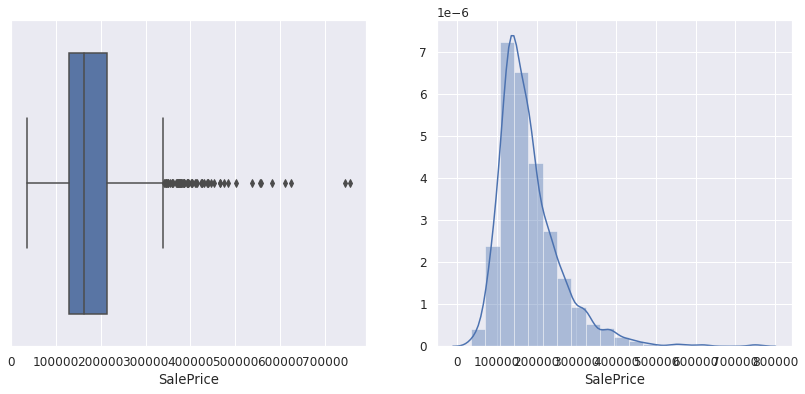

In [37]:
#Visualize target variable data 
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.boxplot(train_df.SalePrice)
plt.subplot(1,2,2)
sns.distplot(train_df.SalePrice, bins=20)
plt.show()

2.3.3 Checking for potential outliers using the IQR rule

In [38]:
# Identify potential outliers
info = train_df.SalePrice.describe()
print(info)
IQR = info['75%'] - info['25%']
upper = info['75%'] + 1.5 * IQR
lower = info['25%'] - 1.5 * IQR
print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper, lower))

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
The upper and lower bounds for suspected outliers are 340037.5 and 3937.5.


2.3.4 Investigate identified outliers

In [39]:
#checking lower bound suspected outliers 
train_df[train_df.SalePrice < 3937.5].count()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 80, dtype: int64

In [40]:
#checking lower bound suspected outliers 
train_df[train_df.SalePrice > 340037.5].count()

MSSubClass       61
MSZoning         61
LotFrontage      58
LotArea          61
Street           61
                 ..
MoSold           61
YrSold           61
SaleType         61
SaleCondition    61
SalePrice        61
Length: 80, dtype: int64

In [41]:
#checking lower bound suspected outliers 
train_df[train_df.SalePrice > 340037.5]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
11            60       RL         85.0    11924   Pave   NaN      IR1   
53            20       RL         68.0    50271   Pave   NaN      IR1   
58            60       RL         66.0    13682   Pave   NaN      IR2   
112           60       RL         77.0     9965   Pave   NaN      Reg   
151           20       RL        107.0    13891   Pave   NaN      Reg   
...          ...      ...          ...      ...    ...   ...      ...   
1268          50       RL          NaN    14100   Pave   NaN      IR1   
1353          50       RL         56.0    14720   Pave   NaN      IR1   
1373          20       RL          NaN    11400   Pave   NaN      Reg   
1388          20       RL         42.0    14892   Pave   NaN      IR1   
1437          20       RL         96.0    12444   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
11           Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
53           Low    AllPub    Inside  ...        0    NaN   NaN         NaN   
58           HLS    AllPub   CulDSac  ...        0    NaN   NaN         NaN   
112          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
151          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
...          ...       ...       ...  ...      ...    ...   ...         ...   
1268         Lvl    AllPub    Inside  ...        0    NaN  GdWo         NaN   
1353         Lvl    AllPub   CulDSac  ...        0    NaN   NaN         NaN   
1373         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1388         HLS    AllPub   CulDSac  ...        0    NaN   NaN         NaN   
1437         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
11         0      7    2006       New        Partial     345000  
53         0     11    2006        WD         Normal     385000  
58         0     10    2006       New        Partial     438780  
112        0     10    2007       New        Partial     383970  
151        0      1    2008       New        Partial     372402  
...      ...    ...     ...       ...            ...        ...  
1268       0      5    2008        WD         Normal     381000  
1353       0      3    2010        WD         Normal     410000  
1373       0      3    2007        WD         Normal     466500  
1388       0     10    2009        WD         Normal     377500  
1437       0     11    2008       New        Partial     394617  

[61 rows x 80 columns]

Findings: All these are invalid data considering the various jobtypes are more likely not to be volunteers. Hence the data needs to be dropped.

In [42]:
train_df.LotArea.describe()

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

In [43]:
train_df[train_df.SalePrice > 340037.5].groupby(['YearBuilt']).size()

YearBuilt
1892     1
1934     1
1935     1
1965     1
1972     1
1981     1
1992     1
1993     1
1994     2
1995     4
1996     1
1997     1
2001     1
2003     5
2004     2
2005     6
2006    10
2007     5
2008    11
2009     4
2010     1
dtype: int64

In [44]:
train_df[train_df.SalePrice > 340037.5].groupby(['Neighborhood']).size()

Neighborhood
CollgCr     2
Crawfor     3
Gilbert     1
NAmes       1
NoRidge    11
NridgHt    27
OldTown     1
Somerst     2
StoneBr     9
Timber      3
Veenker     1
dtype: int64

Observations:

1. The 61 properties with SalePrice higher than the upper bounds are mostly:
   - MSSubClass - 20 & 60 
   - Residential Low Density in NridgHt, NoRidge & StoneBr Neighborhoods.
   - LotAreas higher than the mean LotArea size and 
   - Built in the 2000s.

In [21]:
# Filling 'LotFrontage' according to Neighborhood.
analysis_data['LotFrontage'] = analysis_data.groupby(
    ['Neighborhood'])['LotFrontage'].apply(lambda x: x.fillna(x.median()))

NameError: name 'analysis_data' is not defined

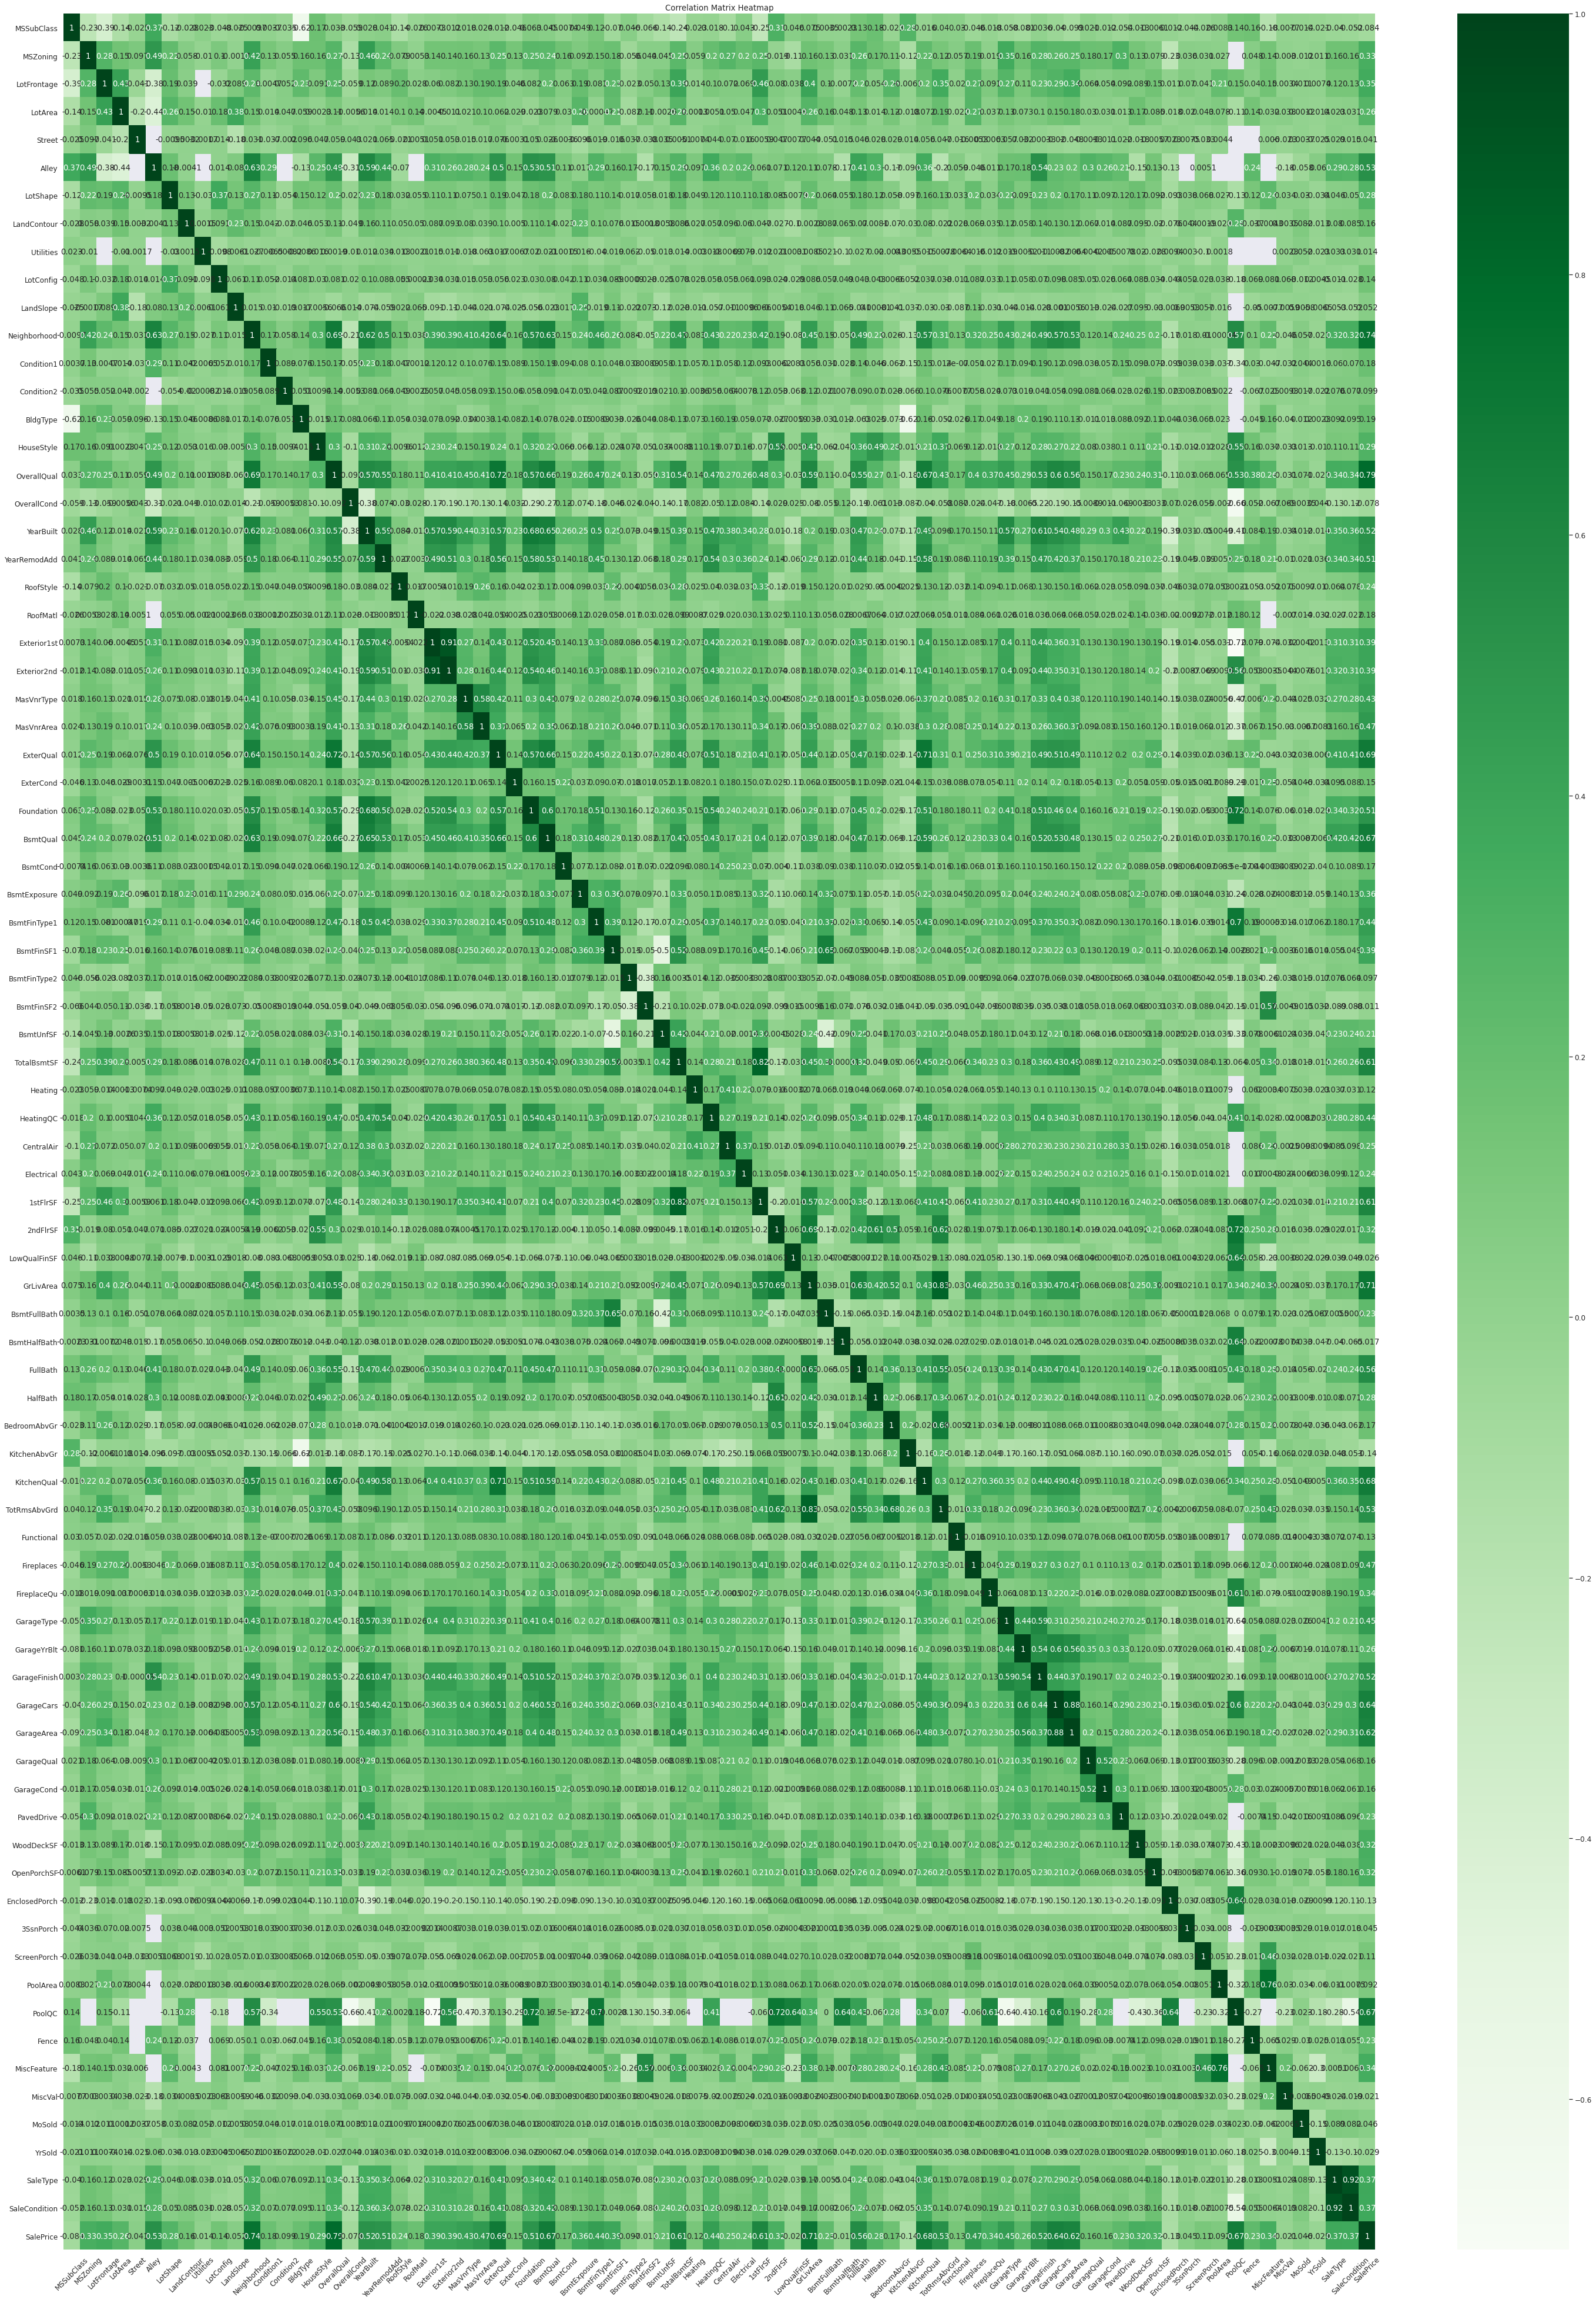

In [102]:
#Create Heatmap to highlight the correlations
fig = plt.figure(figsize=(50, 70))
features = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
analysis_data[features] = analysis_data[features].astype(float)
sns.heatmap(analysis_data[features + ['SalePrice']].corr(), cmap='Greens', annot=True)
plt.xticks(rotation=45)
plt.title('Correlation Matrix Heatmap')
plt.show()

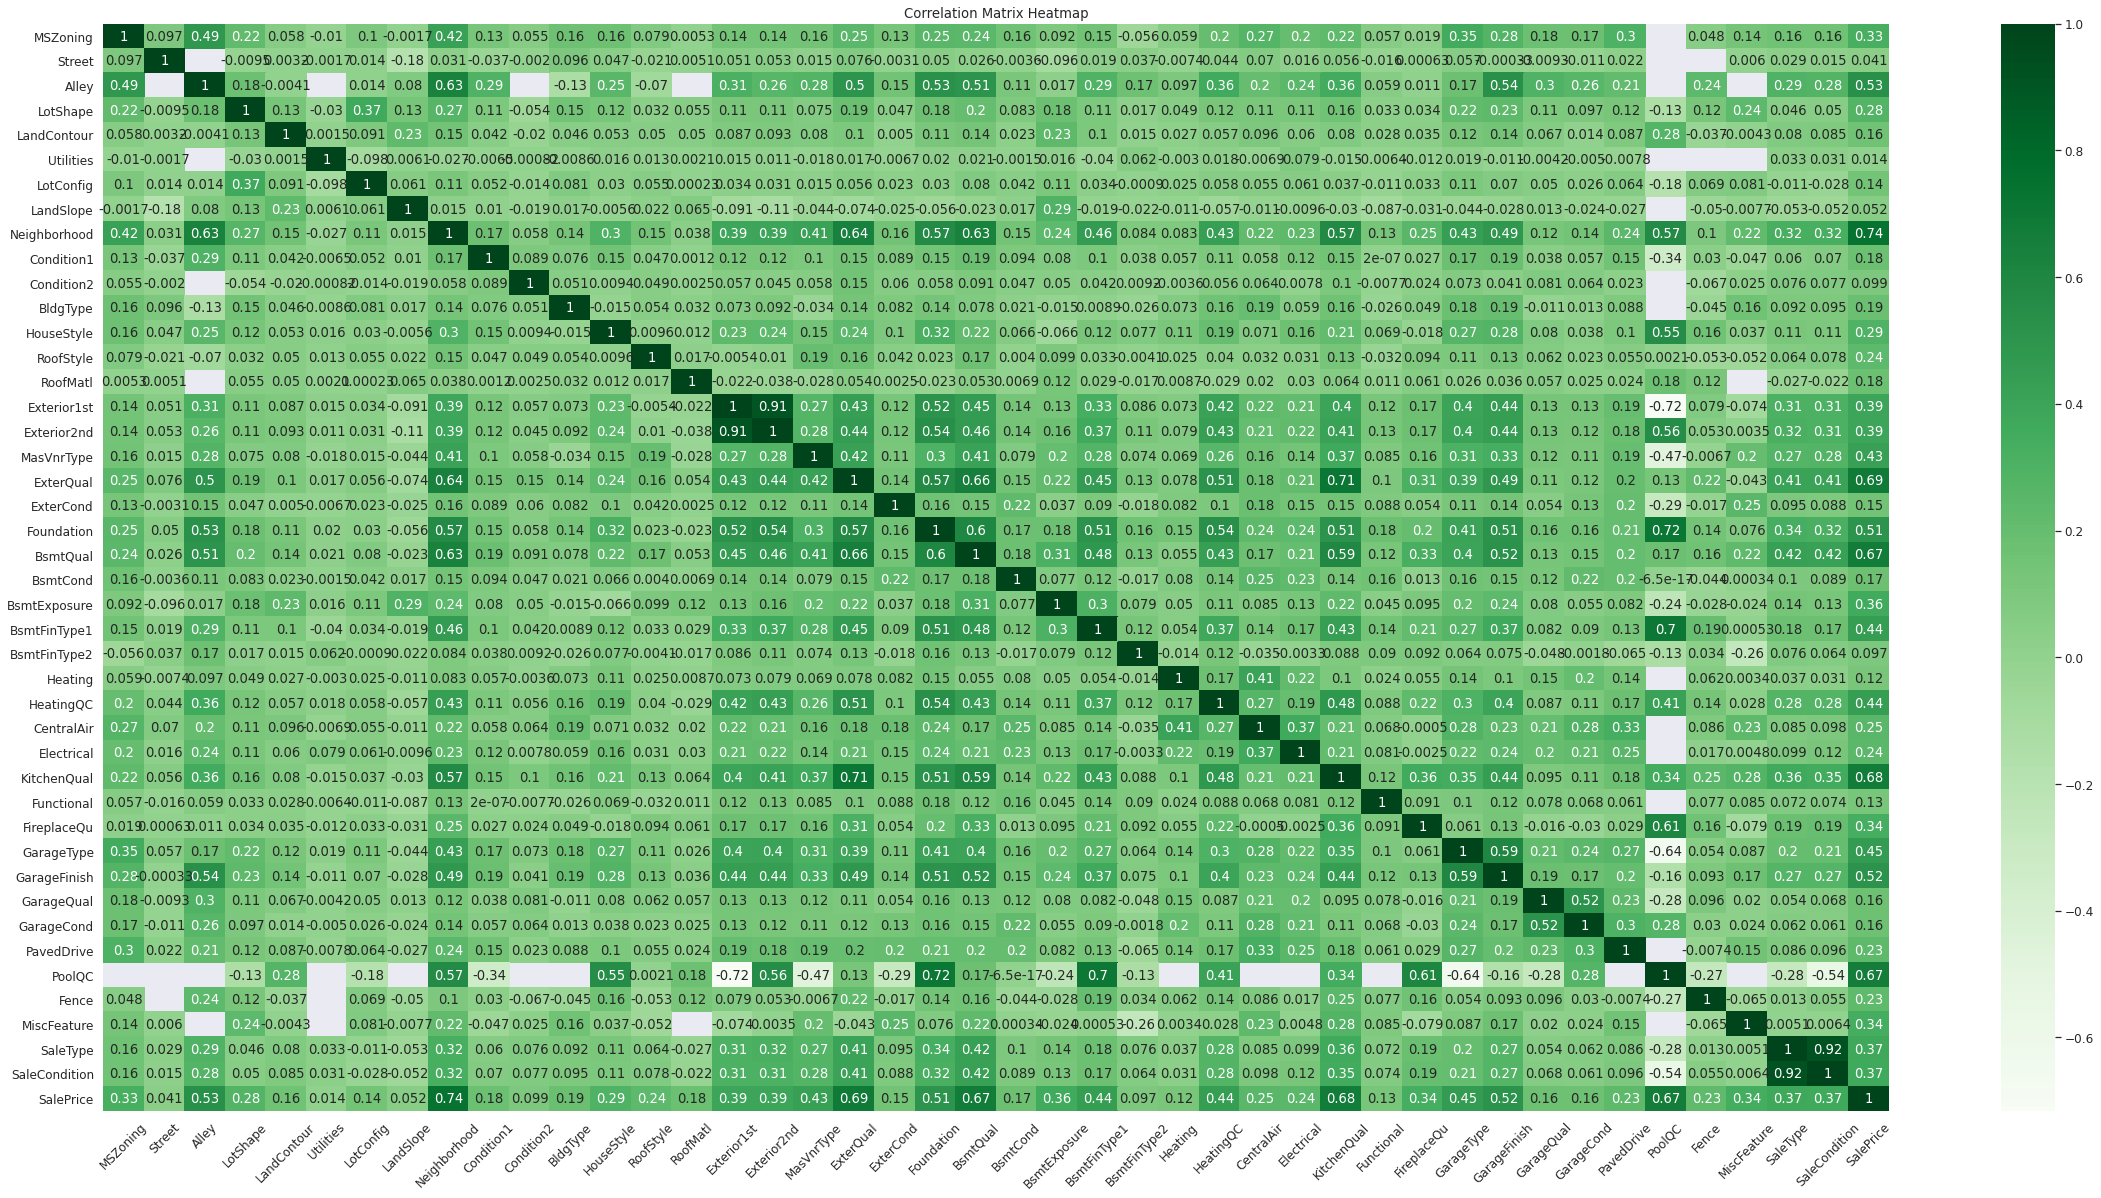

In [111]:

#Create Heatmap to highlight the correlations
fig = plt.figure(figsize=(40, 20))
features = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition']
analysis_data[features] = analysis_data[features].astype(float)
sns.heatmap(analysis_data[features + ['SalePrice']].corr(), cmap='Greens', annot=True)
plt.xticks(rotation=45)
plt.title('Correlation Matrix Heatmap')
plt.show()

### 2.4 EDA - Data Exploration

2.4.1 Summary of Feature and Target Variables

In [ ]:
#summarize variables
merged_train_data.describe(include = "all")

2.4.2 Review correlation between each feature and the target variable

In [ ]:
# Function to create plots to check correlation of features with the target variable
def feature_plot(df, col):
    plt.figure(figsize = (14, 6))
    plt.subplot(1, 2, 1)  

    if df[col].dtype == 'int64':
        df[col].value_counts().sort_index().plot()
    elif col == 'companyId':
        mean = df.groupby(col)['salary'].mean()
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace = True)
        df[col].value_counts().plot()
    else:
        #change the categorical variable to category type and order their level by the mean salary
        #in each category
        frequency = df[col].value_counts()
        sub_categories = pd.unique(df[col])
        sns.barplot(x = sub_categories, y = frequency, data = df)
    plt.xticks(rotation = 45)
    plt.xlabel(col)
    plt.ylabel('counts')
    plt.subplot(1, 2, 2)
    
    if df[col].dtype == 'int64' or col == 'companyId':
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
    else:
        sns.boxplot(x = col, y = 'salary', data = df)
        
    plt.xticks(rotation = 45)
    plt.ylabel('salaries')
    plt.show()

2.4.2.1 Correlation between Companies (feature variable) and Salary (target variable)

In [ ]:
feature_plot(merged_train_data, 'companyId')

Findings: There are 63 different companies with varying number of samples in the dataset. Plot shows that there is generally a weak correlation between companies and salaries. There is no significant increase in the mean salary across companies.

2.4.2.2 Correlation between Job Types (feature variable) and Salary (target variable)

In [ ]:
feature_plot(merged_train_data, 'jobType')

Findings: There are 8 different job types with similar number of samples in the training dataset from junior level (janitor) to senior level Chief Executive Officer (CEO). As anticipated the plot shows salary bands increase relative to the level of role seniority in the organization which indicates a positive correlation between job type and salary. 

2.4.2.3 Correlation between Degrees (feature variable) and Salary (target variable)

In [ ]:
feature_plot(merged_train_data, 'degree')

In [ ]:
merged_train_data.loc[merged_train_data.degree == 'NONE', 'jobType'].value_counts()

Findings: There are 5 different levels of degrees with varying samples in the training dataset from No Degree (None) to Doctoral. The Janitors have the highest number of samples in the NONE degree category, which is understandable. The plot shows the more advanced degrees show a positive correlation to salary.

2.4.2.4 Correlation between Majors (feature variable) and Salary (target variable)

In [ ]:
feature_plot(merged_train_data, 'major')

In [ ]:
merged_train_data.loc[merged_train_data.major == 'NONE', 'jobType'].value_counts()

Findings: There are 8 different major types and 1 type with no majors (None).  Data shows the NONE major type employees are mostly janitors. The plot shows weak correlation between Majors and Salary. The plot also shows the NONE major group are the lowest salary band as typically anticipated and there are more Maths major employees in the data set.

2.4.2.5 Correlation between Industries (feature variable) and Salary (target variable)

In [ ]:
feature_plot(merged_train_data, 'industry')

Findings: There are 7 industries with similar number of samples in the training dataset. Generally there is a weak correlation between industry and salary. The plot also shows oil and finance industries generally have higher compensation band.

2.4.2.6 Correlation between Years of Experience (feature variable) and Salary (target variable)

In [ ]:
feature_plot(merged_train_data, 'yearsExperience')

Findings: The years of experience range from 0 - 24 years across the training dataset. The plot shows a positive correlation between years of experience and salary.

2.4.2.7 Correlation between Miles From Metropolis (feature variable) and Salary (target variable)

In [ ]:
feature_plot(merged_train_data, 'milesFromMetropolis')

Findings: The farthest distance from metropolis in 99 miles. The plot shows a negative correlation between miles from metropolis and salary. 

2.4.3 Identify correlation between features

The following function is applied to all columns of the dataframe and encodes the subcategories with the mean of the salary of each category respectively.

In [ ]:
def encode_label(df, col):
    cat_dict = {}
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = merged_train_data[merged_train_data[col] == cat]['salary'].mean()
    df[col] = df[col].map(cat_dict)

In [ ]:
#Create a copy the train dataframe to use for analysis
analysis_data = merged_train_data.copy()

In [ ]:
#apply the encode_label function on categorical data
for col in analysis_data.columns:
  if analysis_data[col].dtype.name == 'category':
    encode_label(analysis_data, col)

In [ ]:
analysis_data.describe()

In [ ]:
#Create Heatmap to highlight the correlations
fig = plt.figure(figsize=(20, 10))
features = ['companyId', 'jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']
analysis_data[features] = analysis_data[features].astype(int)
sns.heatmap(analysis_data[features + ['salary']].corr(), cmap='Greens', annot=True)
plt.xticks(rotation=45)
plt.title('Correlation Matrix Heatmap')
plt.show()

Findings: The heatmap shows Major and Degree have the highest positive strong correlation whilst Jobtype is moderately correlated to Degree and Major. JobType has the strongest correlation with salary, then degree, major and yearsExperience in that correlation order.

### 2.5 Establish a baseline

2.5.1 First step is to create a simple baseline model. Job Type has the strongest correlation to salary hence we wil utilise the average salary based on jobType subcategories as our prediction algorithm and then measure the result using MSE as the metric.

In [ ]:
# This function predicts salary based on subcategories of a given categorical feature
def average_based_salary_predictor(df, col):
    cat_dict = {}
    salary_prediction = []
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = merged_train_data[merged_train_data[col] == cat]['salary'].mean()
    salary_prediction = df[col].map(cat_dict)
    return salary_prediction

In [ ]:
# We apply the function on job type and calculate the score
baseline_mse = mse(merged_train_data['salary'], average_based_salary_predictor(merged_train_data, 'jobType'))
print('The baseline mean squared error =',baseline_mse )

With a baseline mean squared error established, our next task is to improve the score.

### 2.6 Hypothesize Solution

Considering the baseline model salary prediction is based on data provided without fitting, feature generation or model tuning we will utilize supervised machine learning algorithms to improve the accuracy of the predicted salaries.

The salary prediction expected output is a continuous value hence we will use from the suite of regression supervised learning algorithms. 

1. Linear Regression - simple to implement and easier to interpret the output coefficients.
2. Linear Regression with Interaction variables - explore the significance of relationships between various features.
3. Random Forest Regressor - improves the accuracy by reducing overfitting problem and the variance in decision trees.
4. GradientBoostingRegressor - Typically produces best predictions because it can optimize on different loss functions and provides several hyperparameter tuning options that make the function fit very flexible.

## Part 3 - DEVELOP

### 3.1 Feature Engineering 

Most machine learning models can only handle numerical values.

In order to get the data ready for modelling we will transform categorical features into individual binary feature using the one hot encoding approach. 

In [ ]:
#This function one-hot-encodes all the categorical features and combines them with numerical ones
def one_hot_encode_data (df, cat_vars = None, num_vars = None):
    cat_df = pd.get_dummies(df[['jobType', 'major', 'degree', 'industry']], drop_first=True)
    num_df = df[['yearsExperience', 'milesFromMetropolis', 'salary']].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis = 1, ignore_index = False)

In [ ]:
model_data = one_hot_encode_data(merged_train_data, cat_vars = None, num_vars = None)

In [ ]:
model_data.describe()

In [ ]:
model_data.columns

In [ ]:

features = ['jobType_CFO', 'jobType_CTO', 'jobType_JANITOR', 'jobType_JUNIOR',
       'jobType_MANAGER', 'jobType_SENIOR', 'jobType_VICE_PRESIDENT',
       'major_BUSINESS', 'major_CHEMISTRY', 'major_COMPSCI',
       'major_ENGINEERING', 'major_LITERATURE', 'major_MATH', 'major_NONE',
       'major_PHYSICS', 'degree_DOCTORAL', 'degree_HIGH_SCHOOL',
       'degree_MASTERS', 'degree_NONE', 'industry_EDUCATION',
       'industry_FINANCE', 'industry_HEALTH', 'industry_OIL',
       'industry_SERVICE', 'industry_WEB', 'yearsExperience',
       'milesFromMetropolis']
feature_train, feature_tune, target_train, target_tune = train_test_split(model_data[features], model_data['salary'], test_size=0.33, random_state=0, shuffle=True)

### 3.2 Models Creation

3.2.1 As mentioned in section 2.6 above, 4 algorithms are used to create the models in this project. Hyperparameter tuning was done using the Google Colab TPU platform due to large computing resources required. The parameters used for the models are the results of the tuning process.

In [ ]:
# create models
# Model 1: Linear Regression
LinearRegression = lr()
# Model 2: Linear Regression with Interaction
LR_interaction = lr()
# Model 3: Random Forest and Gradient Boosting
rfr = rfregr(random_state=42, n_estimators=200, max_depth=40, criterion='mse', min_samples_split=40, max_features=15)
# Model 4: Random Forest and Gradient Boosting
grb = grbregr(random_state=42, n_estimators=200, criterion='mse', min_samples_split=2, max_depth=10, min_samples_leaf=40, subsample=1, learning_rate=0.08)

3.2.2 Steps of hyperparameter tuning done with Random Grid Search using the Google Colab TPU platform for Random Forest Model

In [ ]:
rf = rfregr(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())
#Parameters currently in use:

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = [3, 6, 9, 12, 15]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(6, 60, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [20, 40, 60, 80]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = rfregr()
# Random search of parameters, using 3 fold cross validation, 
# search across 4 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(feature_train, target_train)

In [ ]:
#View the best parameters from fitting the random search:
rf_random.best_params_

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = rfregr(n_estimators = 100, random_state = 42)
base_model.fit(feature_train, target_train)
base_accuracy = evaluate(base_model, feature_tune, target_tune)

In [ ]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, feature_tune, target_tune)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

3.2.3 Steps of hyperparameter tuning done using the Google Colab TPU platform for Gradient Boost Model

In [ ]:
def select_params(feature_train, target_train, feature_tune, target_tune, max_estimators=1000, max_depth = 3, learning_rate=0.01):

    #feature_train, feature_tune, target_train, target_tune = train_test_split(model_data[features], model_data['salary'], test_size=0.33, random_state=0, shuffle=True)
    
    gbm = grbregr(n_estimators = max_estimators, learning_rate=learning_rate, 
                                    max_depth=max_depth, loss='ls', subsample=1.0)

    gbm.fit(feature_train, target_train)

    test_score = np.zeros(max_estimators)

    for i, y_pred in enumerate(gbm.staged_predict(feature_tune)):
        test_score[i] = mse(target_tune, y_pred)
        
    print('optimal number of trees: {0}'.format(test_score.argmin()))
    print('best MSE: {0}'.format(test_score.min()))
    # print('baseline MSE: {0}'.format(mse(target_tune, target_train.median())))
    pd.Series(test_score).plot(title='learning curve for max_depth = {0}'.format(max_depth))
    plt.show()

In [ ]:
for depth in [6, 8, 10, 12]:
    print('***** training for max depth = {0} *****'.format(depth))
    select_params(feature_train, target_train, feature_tune, target_tune, max_estimators=40, max_depth=depth, learning_rate=0.1)

Max Depth of 10 computes best MSE, next we tune for Max Estimator.

In [ ]:
for max_e in [100, 200, 300, 400]:
    print('***** training for max estimators = {0} *****'.format(max_e))
    select_params(feature_train, target_train, feature_tune, target_tune, max_estimators=max_e, max_depth=10, learning_rate=0.08)

### 3.3 Models Evaluation

3.3.1 Compile the selected models for evaluation

In [ ]:
# create models
models_eval = []
models_eval.append(('LinearRegression', lr()))
models_eval.append(('LR_interaction', lr()))
models_eval.append(('RandomForest', rfregr(random_state=42, n_estimators=200, max_depth=40, criterion='mse', min_samples_split=40, max_features=15)))
models_eval.append(('GradientBoosting', grbregr(random_state=42, n_estimators=200, criterion='mse', min_samples_split=2, max_depth=10, min_samples_leaf=40, subsample=1, learning_rate=0.08)))

print(models_eval)

3.3.2 This function is to create variables for the Logistic Regression with Interaction model.

In [ ]:
def create_interactions(data):
    interactions = PolynomialFeatures(interaction_only=True, include_bias=False)
    interaction_vars = interactions.fit_transform(data)
    return interaction_vars

3.3.3 Interaction variables are created for the split feature training data

In [ ]:
# Creating interaction variables
interaction_vars = create_interactions(feature_train)
interaction_vars

3.3.4 This function is to evaluate the models using the cross validation technique on the split feature training data

In [ ]:
scoring='neg_mean_squared_error'

avg_scores = []
std_dev = []
model_names = []

for model_name, model in tqdm(models_eval):
  if model_name == 'LR_interaction':
    score = cvs(model, interaction_vars, target_train, cv=5, scoring='neg_mean_squared_error')
    scores = abs(score) # MSE scoring is negative in cross_val_score
    avg_score = np.mean(scores)
    std = np.std(scores)
    avg_scores.append(avg_score)
    std_dev.append(std) 
  else:
    score = cvs(model, feature_train, target_train, cv=5, scoring='neg_mean_squared_error')
    scores = abs(score) # MSE scoring is negative in cross_val_score
    avg_score = np.mean(scores)
    std = np.std(scores)
    avg_scores.append(avg_score)
    std_dev.append(std) 
  output = "%s: %f (%f)" % (model_name, avg_score, std)
  print(output)

### 3.4 Models Testing

3.4.1 This function is to test the prediction from each model on the split feature testing data

In [ ]:
scoring='neg_mean_squared_error'

MSE_scores = []
std_dev_test = []
model_names_test = []

for model_name, model in tqdm(models_eval):
  if model_name == 'LR_interaction':
    model_test = model.fit(interaction_vars, target_train)
    test_interaction_var = create_interactions(feature_tune)
    prediction = model_test.predict(test_interaction_var)
    MSE_score = mse(target_tune, prediction)
    MSE_scores.append(MSE_score)
  else:
    model_test = model.fit(feature_train, target_train) 
    prediction = model_test.predict(feature_tune)
    MSE_score = mse(target_tune, prediction)
    MSE_scores.append(MSE_score)
  output = "%s: %f" % (model_name, MSE_score)
  print(output)

In [ ]:
MSE_scores = [384.6302037213719, 354.7601865387493, 368.3133273997825, 359.8805986584317]
MSE_scores

In [ ]:
def models_scores_plot():
    all_scores = MSE_scores
    names = ['Linear Regression', 'Linear Regression with Interactions', 'Random Forest', 'Gradient Boosting']
    fig, ax = plt.subplots(figsize=(15,7))
    plt.style.use('dark_background')
    plt.ylabel('MSE_scores', fontsize=15, fontweight='bold')
    plt.xlabel('models_eval', fontsize=15, fontweight='bold')
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    ax.bar(names, MSE_scores)
    plt.show()

In [ ]:
models_scores_plot()

Findings :  Linear Regression with interactions has the best MSE value of ~355. Hence it will be used to predict the predict the test dataset.

### 3.5 Best Model Selection

In [ ]:
bestModel = LR_interaction
bestModel

## Part 4 - DEPLOY

### 4.1 Train best model selected on the entire training data

4.1.1 Interaction variables are created for the entire training data 

In [ ]:
# Creating interaction variables
full_train_vars = create_interactions(model_data[features])
full_train_vars

4.1.2 The best model is fitted to the entire training data using the interaction variables created in section 4.1.1 above. 

In [ ]:
#Train best model on the whole training data
bestModel.fit(full_train_vars, model_data['salary'])

### 4.2 Score the Test Dataset

4.2.1 Test data was inspected and explored in section 2.2.1 above. No null values identified. The data will undergo same encoding and manipulation routine to match the shape of the train dataset.

This function is to perform feature engineering on the test data

In [ ]:
#This function one-hot-encodes all the categorical features and combines them with numerical ones
def one_hot_encode_testdata (df, cat_vars = None, num_vars = None):
    cat_df = pd.get_dummies(df[['jobType', 'major', 'degree', 'industry']], drop_first=True)
    num_df = df[['yearsExperience', 'milesFromMetropolis']].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis = 1, ignore_index = False)

4.2.2 Test data encoded using funtion defined in section 4.2.1 above.

In [ ]:
#encoding test dataset
test_data = one_hot_encode_testdata(test_features, cat_vars = None, num_vars = None)
test_data.head(10)

4.2.3 Interaction variables are created for the test dataset

In [ ]:
# Creating interaction variables
test_data_vars = create_interactions(test_data)
test_data_vars

4.2.4 Salary predictions based on test data features are generated using the selected best model

In [ ]:
salary_predictions = bestModel.predict(test_data_vars)
salary_predictions

4.2.5 Combine the original test data and the predicted salaries

In [ ]:
# updating the test dataset with the additional 'predisted_salary' column
test_features['salary'] = salary_predictions.tolist()

In [ ]:
test_features.head(20)

4.2.6 Export the final dataset to a csv file

In [ ]:
#Exporting the final predicted dataset to a csv file
test_features.to_csv('test_salaries.csv')

### 4.3 Feature Importance

4.3.1 Fit the Gradient Boosting Model to the coded training data to compute feature importance

In [ ]:
grb.fit(model_data[features], model_data['salary'] )

4.3.2 Generate and plot the sorted feature importance data.

In [ ]:
# store feature importances

if hasattr(grb, 'feature_importances_'):
    importances = grb.feature_importances_

else:
    # for linear models which don't have feature_importances_
    importances = [0]*len(model_data[features].columns)

feature_importances = pd.DataFrame({'feature':model_data[features].columns, 'importance':importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    
# set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)
    
# create plot
feature_importances[0:25].plot.bar(figsize=(20,10))
plt.show()

Findings :  Plot shows the importance of each feature in the prediction of the salary. Years of experience and Miles From Metropolis are in the 10 features.

### 4.4 Summarize the predicted Salaries

We'll skip this step since we don't have the outcomes for the test data

In [ ]:
#Visualize target variable data 
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.boxplot(test_features.salary)
plt.subplot(1,2,2)
sns.distplot(test_features.salary, bins=20)
plt.show()

In [ ]:
#summarize variables
test_features.describe(include = "all")

In [ ]:
# Function to create plots to check correlation of features with the target variable
def feature_plot(df, df2, col):
    plt.figure(figsize = (14, 6))
    plt.subplot(1, 2, 1)
    if df[col].dtype == 'int64' or col == 'companyId':
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
    else:
        sns.boxplot(x = col, y = 'salary', data = df)
        
        plt.xticks(rotation = 45)
        plt.ylabel('salaries')
        plt.title('Training Data')
    plt.subplot(1, 2, 2)
    if df2[col].dtype == 'int64' or col == 'companyId':
        mean = df2.groupby(col)['salary'].mean()
        std = df2.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.4)
    else:
        sns.boxplot(x = col, y = 'salary', data = df2)
        
        plt.xticks(rotation = 45)
        plt.ylabel('Predicted salaries')
        plt.title('Test Data')
        plt.show()

In [ ]:
feature_plot(merged_train_data, test_features, 'companyId')

In [ ]:
feature_plot(merged_train_data, test_features, 'jobType')

In [ ]:
feature_plot(merged_train_data, test_features, 'degree')

In [ ]:
feature_plot(merged_train_data, test_features, 'major')

In [ ]:
feature_plot(merged_train_data, test_features, 'industry')

In [ ]:
feature_plot(merged_train_data, test_features, 'yearsExperience')

In [ ]:
feature_plot(merged_train_data, test_features, 'milesFromMetropolis')